# Stroke Prediction

The aim of this project is to create a model to predict as accurately as possible who is more likely to suffer a stroke and who not. In addition, we will do a bit of of explanatory analysis and aim to find potential risk factors.

Find the dataset [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

The notebook is organised like:
- Data cleaning and exploration
- Inferential Analysis
- Data pre-processing
- Modelling
- Model interpretation
- Deployment
- Conclusions & limitations


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import uniform
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV,
    KFold,
    StratifiedKFold,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
    roc_auc_score,
    f1_score,
    precision_score,
    accuracy_score,
    get_scorer_names,
    make_scorer,
    precision_recall_curve,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    PolynomialFeatures,
    LabelBinarizer,
    LabelEncoder,
    MultiLabelBinarizer,
)
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    VotingClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.utils import class_weight, compute_class_weight
from lazypredict.Supervised import LazyClassifier
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import eli5
from eli5.sklearn import PermutationImportance
import shap
import pickle
import gradio as gr

In [ ]:
sns.set_style("white")
sns.set_palette("ch:.25")
warnings.filterwarnings("ignore")
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.options.display.float_format = "{:,.2f}".format

# Part 1: Data exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
stroke = pd.read_csv("/content/drive/MyDrive/colab_data_sources/stroke.csv")
print(
    f"There are {stroke.shape[0]} cases and {stroke.shape[1]} features in this dataset."
)

There are 5110 cases and 12 features in this dataset.


In [ ]:
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [ ]:
stroke.columns = stroke.columns.str.lower()

In [ ]:
duplicate_check = stroke.iloc[:, 1:12]
full_duplicates = duplicate_check.duplicated().sum()
print(f"There are {full_duplicates} fully duplicated cases.")

There are 0 fully duplicated cases.


In [ ]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


* Only for bmi there are missing values.
* Even though XGBoost, LightGBM, and CatBoost are able to handle missing values by themselves, GradientBoostingClassifier, knn and others do not.
* Missing values will get a value imputed in the pre-processing pipeline later on.

## Numerical features

In [ ]:
stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,"5,110.00","5,110.00","5,110.00","5,110.00","5,110.00","4,909.00","5,110.00"
mean,"36,517.83",43.23,0.10,0.05,106.15,28.89,0.05
std,"21,161.72",22.61,0.30,0.23,45.28,7.85,0.22
min,67.00,0.08,0.00,0.00,55.12,10.30,0.00
25%,"17,741.25",25.00,0.00,0.00,77.25,23.50,0.00
50%,"36,932.00",45.00,0.00,0.00,91.88,28.10,0.00
75%,"54,682.00",61.00,0.00,0.00,114.09,33.10,0.00
max,"72,940.00",82.00,1.00,1.00,271.74,97.60,1.00


* Age ranges from 0 to 82, with an average of 43 which makes that the sample could seemingly be representative for the overall population.
* Hypertension, heart_disease and stroke are all binary 0/1, assumed here that a value of 1 indicates the person has the condition.
* Average glucose level is ranging from 55 to 271, with an average of 106 and a median of 91. Thus, the higher values could be outliers.
* Bmi ranges from 10.3 to 97.6 (BMI calculated as weight in kilograms divided by height in meters squared. [source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5995720/)) The common bmi range is between 18.5 and 30, with values above 30 categorised as obese, thus we suspect outliers here. On the upper range it is hard to set a boundary of what are realistic values, apparently bmi>60 is categorised as super-super obese, but even 80 is not impossible according to the source above. We will calculate with iqr above which value we can consider cases as outliers. On the lower range, 10.3 seems unlikely, however [research](https://pubmed.ncbi.nlm.nih.gov/35569150/) shows it is not uncommon, thus we will not take out cases from the lower side of the range.  
* In this dataset 4.9% of cases has gotten a stroke.

In [ ]:
stroke["hypertension"] = stroke["hypertension"].map({0: "No", 1: "Yes"}).astype(object)
stroke["heart_disease"] = (
    stroke["heart_disease"].map({0: "No", 1: "Yes"}).astype(object)
)

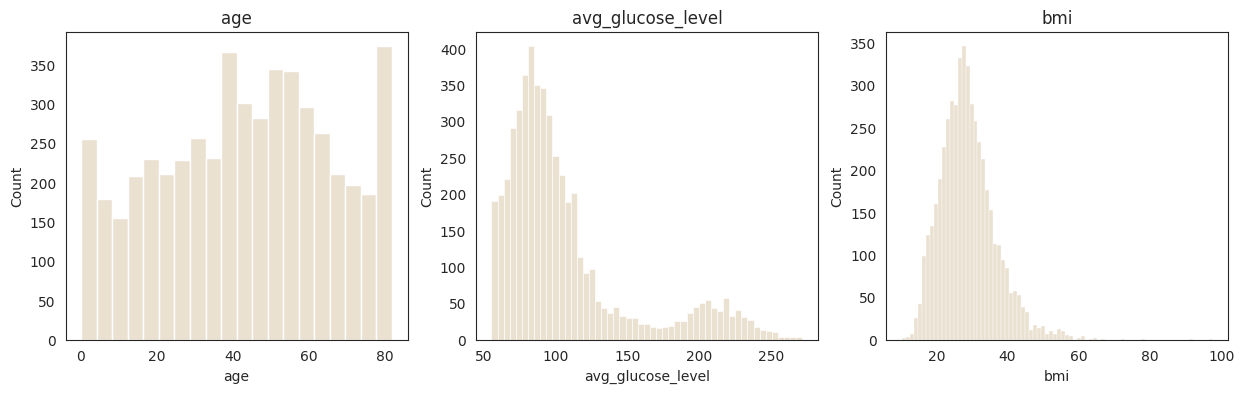

In [ ]:
variables_to_plot = (
    stroke.select_dtypes(include=["float64", "int64"])
    .drop(columns=(["id", "stroke"]))
    .columns
)

num_subplots = len(variables_to_plot)

plt.figure(figsize=(15, 4))

for i, variable in enumerate(variables_to_plot, start=1):
    plt.subplot(1, num_subplots, i)
    sns.histplot(x=stroke[variable])
    plt.title(f"{variable}")

* For age, if not for the high frequency of values around the max, the distribution would have been approximating a normal distribution.
* The average glucose level graph shows two maxima, and thus is a polynomial distribution.


In [ ]:
IQR = 33 - 22.5
lower_value = 22.5 - 1.5 * IQR
upper_value = 33 + 1.5 * IQR
print(f"The lower range is: {lower_value}\nThe upper range is: {upper_value}")

The lower range is: 6.75
The upper range is: 48.75


In [ ]:
outliers = stroke.query("bmi > 48.75")
outliers["id"].count()

95

In [ ]:
stroke.query("bmi > 48.75").describe()

,id,age,avg_glucose_level,bmi,stroke
count,95.00,95.00,95.00,95.00,95.00
mean,"31,578.33",44.92,121.20,55.14,0.02
std,"22,407.74",12.85,58.15,7.71,0.14
min,99.00,14.00,56.63,48.80,0.00
25%,"11,151.50",37.00,79.27,50.35,0.00
50%,"31,145.00",46.00,98.07,53.80,0.00
75%,"49,746.00",53.00,182.15,56.05,0.00
max,"72,911.00",74.00,239.19,97.60,1.00


Looking at the iqr criteria for bmi upper range, 95 cases will be regarded as outliers. Looking at the spread of the values for these cases on other features, we see that only 2% of them, thus 2 cases, suffered a stroke. Thus, this group does not concern a significantly large portion of stroke sufferers.

We will round the values to 1.5*IQR above the 3rth quartile as we have reason to believe that they might be measurement errors or otherwise anomalies, which we do not want to disproportionately affect the model during training. Dropping them would mean data loss, and since these cases do not seem to have any strange values on other features they can still improve predictive value of our model.


In [ ]:
stroke["bmi"] = stroke["bmi"].apply(lambda x: min(x, 48.75))

Below we will take closer look at how features are distributed for people that did suffer a stroke only.

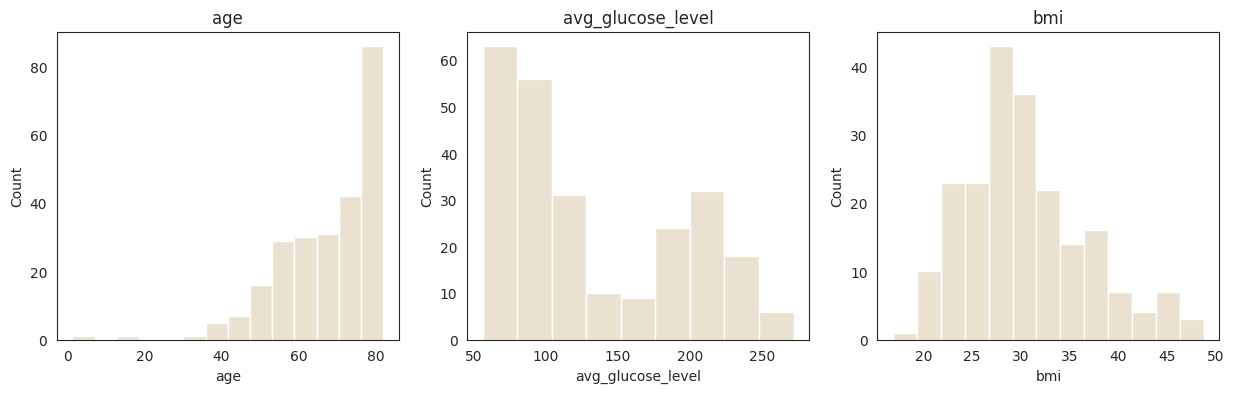

In [ ]:
strokes_only = stroke[stroke["stroke"] == 1]
variables_to_plot = (
    strokes_only.select_dtypes(include=["float64", "int64"])
    .drop(columns=(["id", "stroke"]))
    .columns
)

num_subplots = len(variables_to_plot)

plt.figure(figsize=(15, 4))

for i, variable in enumerate(variables_to_plot, start=1):
    plt.subplot(1, num_subplots, i)
    sns.histplot(x=strokes_only[variable])
    plt.title(f"{variable}")

Looking only at cases that did suffer a stroke, we can see that:
* The age distribution looks different than for the overall sample, clearly the amount of stroke cases goes up with age. The average age of people that suffered a stroke is 67 compared to 43 in the total sample.
* Average glucose levels are distributed pretty much the same as in the total sample, which would mean this is not likely a predictor for a stroke. From this distribution, it seems like very low glucose levels see most strokes, while medium glucose levels are least likely to get a stroke, medium high levels around 200 are more likely again, and very high values are less likely again.
* Bmi is also roughly following the same distribution as for the total sample, and the average is only slightly higher at 30.5 compared to 28.9 in the entire sample.



In [ ]:
strokes_only.describe()

,id,age,avg_glucose_level,bmi,stroke
count,249.00,249.00,249.00,209.00,249.00
mean,"37,115.07",67.73,132.54,30.43,1.00
std,"21,993.34",12.73,61.92,6.19,0.00
min,210.00,1.32,56.11,16.90,1.00
25%,"17,013.00",59.00,79.79,26.40,1.00
50%,"36,706.00",71.00,105.22,29.70,1.00
75%,"56,669.00",78.00,196.71,33.70,1.00
max,"72,918.00",82.00,271.74,48.75,1.00


We will now look at the distributions of people who did and did not suffer a stroke side by side.

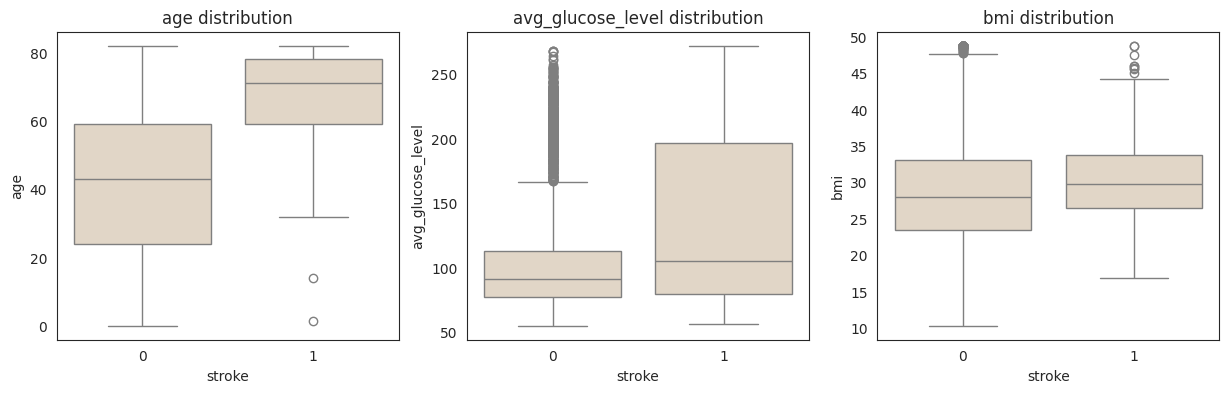

In [ ]:
num_subplots = len(variables_to_plot)

plt.figure(figsize=(15, 4))
for i, variable in enumerate(variables_to_plot, start=1):
    plt.subplot(1, num_subplots, i)
    sns.boxplot(x=stroke.stroke, y=stroke[variable])
    plt.title(f"{variable} distribution")

 * Age distribution differs quite a bit between groups. As noted earlier, the values are around a much higher average for the stroke class.
 * Average glucose levels are more spread with a much wider iqr range for cases with strokes. Medians are actually not that far apart, but still higher for the stroke group. The cases without strokes just show an enormous amount of outliers.
 * BMI starts at a higher point for people that do have strokes, which is not suprpising because the lower range involves children, which are smaller and lighter and are not likely to get strokes yet.

In [ ]:
bin_edges = list(np.linspace(0, 80, 9)) + [float("inf")]
bin_labels = [
    "0-10",
    "11-20",
    "21-30",
    "31-40",
    "41-50",
    "51-60",
    "61-70",
    "71-80",
    "81+",
]
stroke["age_category"] = pd.cut(
    stroke["age"], bins=bin_edges, labels=bin_labels, right=False
)

In [ ]:
age_groups = (
    stroke.groupby("age_category")
    .agg({"id": "count", "stroke": "sum"})
    .rename(columns={"id": "n_total"})
)
age_groups["incidence"] = age_groups.stroke / age_groups.n_total * 100
age_groups

,n_total,stroke,incidence
age_category,,,
0-10,472,1,0.21
11-20,494,1,0.20
21-30,549,0,0.00
31-40,655,6,0.92
41-50,730,12,1.64
51-60,834,48,5.76
61-70,621,47,7.57
71-80,569,94,16.52
81+,186,40,21.51


* The age group 50-60 is most represented in our sample, this group has a risk of roughly 6% of getting a stroke.
* The two lowest age categories are both seeing one stroke case, which brings the prevalence to 0.2% for these age groups, which is higher than for 21-30's. We might consider taking these cases out, as we might find it questionable for our model to learn that 0-20 year olds are more likely to get a stroke than 21-30 year olds.  
* The age group 80+ has highest relative prevalence, however has less cases than the 71-80 group, which is due the this age group being smaller in general.

Text(0.5, 1.0, 'Number of strokes per age group')

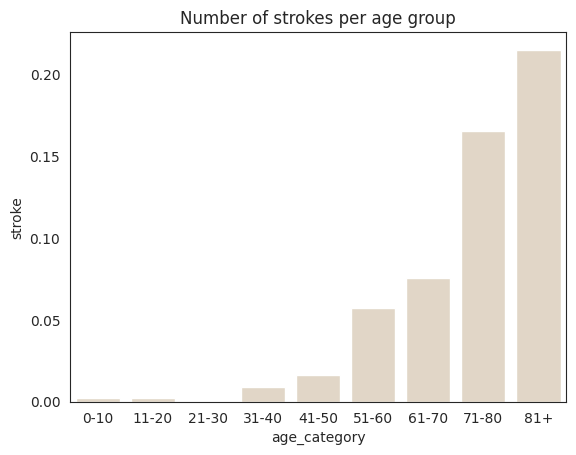

In [ ]:
sns.barplot(x=stroke.age_category, y=stroke.stroke, errorbar=None)
plt.title("Number of strokes per age group");

We can distinguish an even clearer pattern than in the continuous graph, stroke incidence seems to go up roughly exponentially with age category.
We might wonder if average bmi for example, goes up with age group according to the same pattern.  

In [ ]:
age_groups_bmi = (
    stroke.groupby("age_category")
    .agg({"id": "count", "bmi": "mean"})
    .rename(columns={"id": "frequency"})
)
age_groups_bmi

,frequency,bmi
age_category,,
0-10,472,18.87
11-20,494,24.79
21-30,549,27.97
31-40,655,31.04
41-50,730,31.25
51-60,834,31.55
61-70,621,30.93
71-80,569,29.36
81+,186,28.28


Text(0.5, 1.0, 'Average bmi per age group')

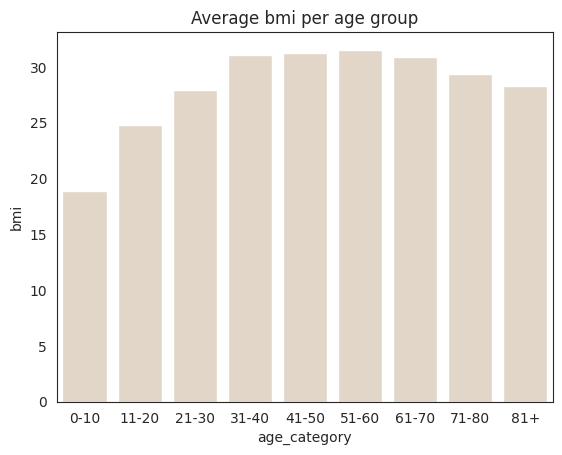

In [ ]:
sns.barplot(x=stroke.age_category, y=stroke.bmi, ci=None)
plt.title("Average bmi per age group");

Bmi and strokes do not follow a linear pattern over the whole range. Until 40 pretty much, after that it is flat for a while. Middle-aged people seem to have highest relative bmi's. After 60, average bmi goes slowly down again, which makes sense as after this age people become more likely to suffer from conditions which might make them more likely to (unintendedly) lose weight.

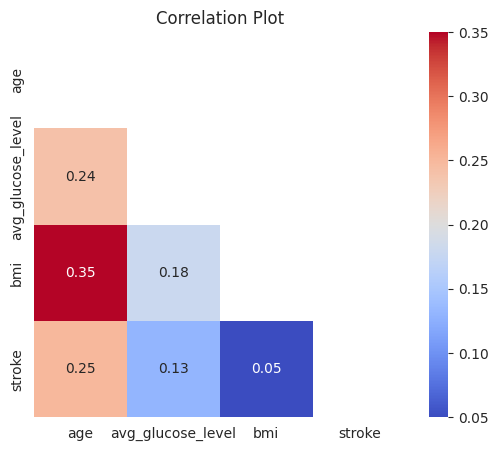

In [ ]:
plt.figure(figsize=(6, 5))
corr_matrix = stroke.drop(columns=("id")).corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", annot=True)
plt.title("Correlation Plot")
plt.show()

## Categorical features

In [ ]:
for col in stroke.columns:
    if stroke[col].dtype == "object":
        print(f"{col}: {stroke[col].unique()}")

gender: ['Male' 'Female']
hypertension: ['No' 'Yes']
heart_disease: ['Yes' 'No']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
gender_marriage: ['Male_Yes' 'Female_Yes' 'Female_No' 'Male_No']


For the work_type feature, children uncapitalized seems a random level between the others. It might indicate maternity or paternity leave, or, since we previously saw the age range of the dataset starts at 0, these might just be kids.

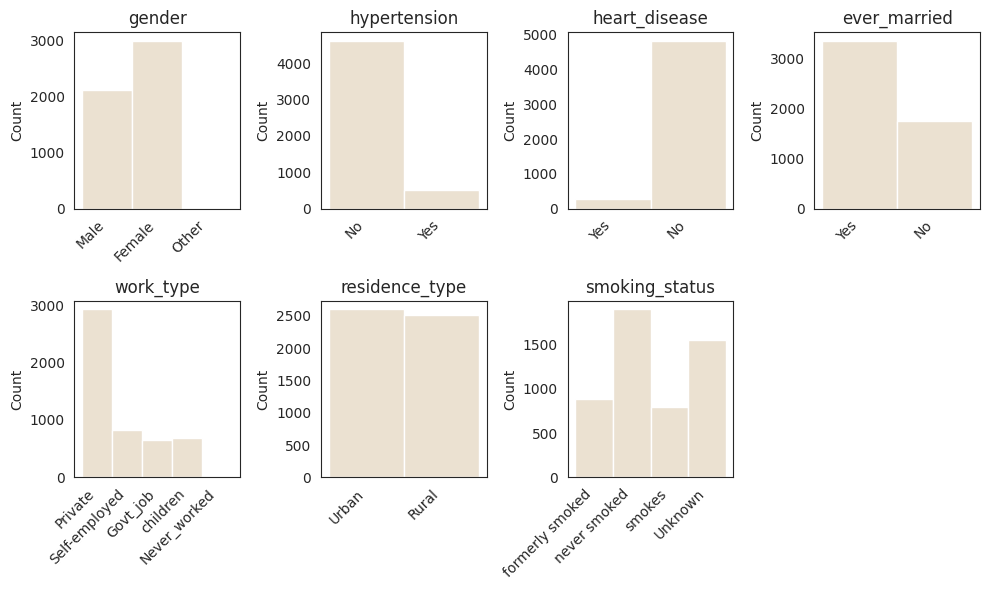

In [ ]:
object_features = stroke.select_dtypes(include=["object"]).columns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))
axes = axes.flatten()

for i in range(7):
    ax = axes[i]
    object_feature = object_features[i]
    sns.histplot(x=object_feature, data=stroke, ax=ax)
    ax.set_title(f"{object_feature}")
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
for i in range(7, 8):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In terms of the categorical features in our dataset we can describe the sample as following:
- The gender distribution is roughly 2:3 for men:women.
- The majority of cases does not have hypertension or heart disease.
- About 2/3 is married.
- The majority of people, roughly 3/5, works in the private sector. Of the remainder, roughly 1/3 is self-employed, anoter 1/3 works for the government and another 1/3 has the level children. The 'never worked' category, seems either empty or very small. We will deepdive below.
* Residence type seems roughly equally distributed.
* For smoking status, it seems like the amount of people that never smoked is as large as the formerly smoked and smoking levels together. However, there is a large amount of unkowns which means the real ratio  between smokers and non-smokers could be significantly different.

In [ ]:
stroke.groupby("gender")[["id"]].count().sort_values("id").rename(
    columns={"id": "total_n"}
)

,total_n
gender,
Other,1
Male,2115
Female,2994


Since the gender category 'other' is only represented by one case, we will get rid of this level.




In [ ]:
stroke = stroke.query("gender != 'Other'")

In [ ]:
stroke.groupby("work_type")[["id"]].count().sort_values("id").rename(
    columns={"id": "total_n"}
)

,total_n
work_type,
Never_worked,22
Govt_job,657
children,687
Self-employed,819
Private,2924


<Axes: xlabel='work_type', ylabel='Count'>

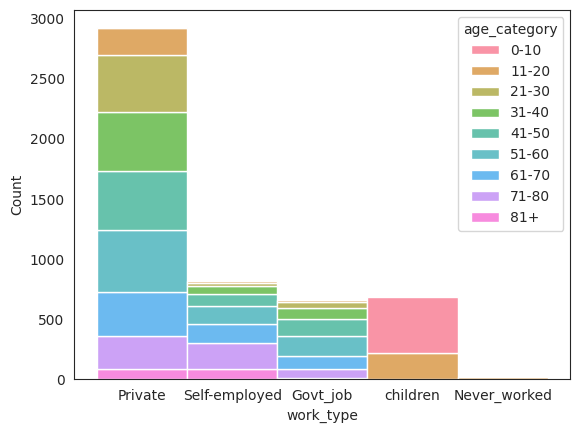

In [ ]:
sns.histplot(x=stroke.work_type, hue=stroke.age_category, multiple="stack");

* The work_type category 'children' only exists of 0-20 year olds, thus children.
* The never worked category are just 11-20 year olds.
* The other three categories seem to be quite evenly spread in terms of age, below we look at differences for these 3 groups in the likelihood of getting a stroke.  


In [ ]:
working = ["Private", "Govt_job", "Self-employed"]
working_inf = stroke[stroke["work_type"].isin(working)].loc[
    :, ["work_type", "hypertension", "heart_disease", "stroke"]
]
working_inf["hypertension"] = (
    working_inf["hypertension"].map({"No": 0, "Yes": 1}).astype(int)
)
working_inf["heart_disease"] = (
    working_inf["heart_disease"].map({"No": 0, "Yes": 1}).astype(int)
)

In [ ]:
working_inf.groupby("work_type").mean()

,hypertension,heart_disease,stroke
work_type,,,
Govt_job,0.11,0.05,0.05
Private,0.10,0.05,0.05
Self-employed,0.18,0.10,0.08


* The risk of getting heart disease seems higher than stroke for all groups.
* A higher proportion of people that are self-employed has hypertension, heart disease and/or stroke, than people working for a company or the government.
* The lowest risk of hypertension and heart disease seems to be amongst people working in the private sector, however this might be due to sampling as the private sector is more represented in this dataset than the other two.

In [ ]:
stroke.groupby("smoking_status")[["id"]].count().rename(columns={"id": "total_n"})

,total_n
smoking_status,
Unknown,1544
formerly smoked,884
never smoked,1892
smokes,789


<Axes: xlabel='smoking_status', ylabel='Count'>

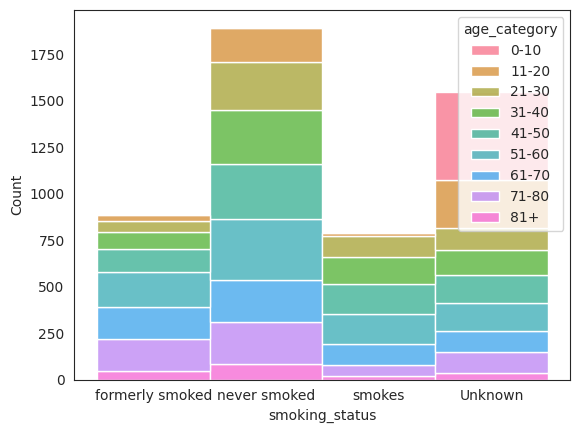

In [ ]:
sns.histplot(x=stroke.smoking_status, hue=stroke.age_category, multiple="stack")

* For smoking status, 30% of cases are in the category 'unknown'. It is the only category that has 0-10 year olds in there, which we would expect to not have smoked. However, all age groups are represented in this category.
* We might want to impute the status of the nearest datapoints using a knn classifier. Or we could justify it being a separate category, as 'unknown' could mean something specific. For example, these people might have vaped, and in case this is self-reported data, people might have doubted whether vaping was included in the smoking definition. There might however be other explanations that we are unaware of with the current dataset, that could make those people form a specific cluster.  

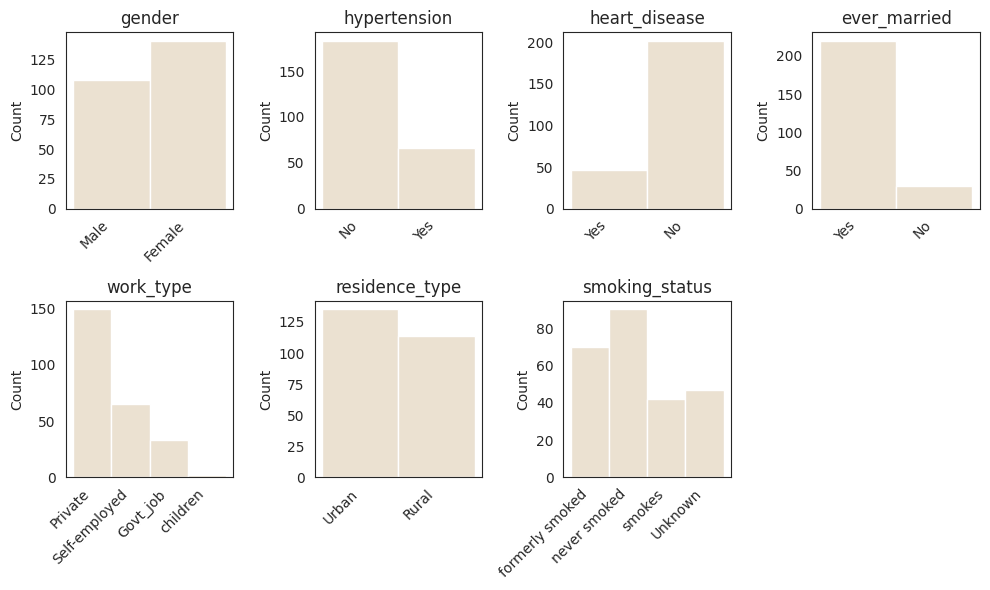

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))
axes = axes.flatten()

for i in range(7):
    ax = axes[i]
    object_feature = object_features[i]
    sns.histplot(x=object_feature, data=strokes_only, ax=ax)
    ax.set_title(f"{object_feature}")
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
for i in range(7, 8):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Looking at the feature distributions of only people that did suffer from a stroke, we noticed: (Beware that this is only 5% of the cases, therefore it should be no surprise if distributions are deviating from those of the whole sample as plotted above)
* More men than women suffered from a stroke. Since there were more women in the overall sample, the % of men that suffers from a stroke should be higher than for women.
* The majority has hypertension and/or heartdisease. Since in the entire sample the majority does not have these conditions, this is an indication that these might be risk factors.
* The majority is or has been married.
* The most common type of work is self-employed, differing from the overall sample where the majority worked a for a company (level: private). We could hypothesize that being self-employed brings more stress and therefore higher risk of stroke. The proportions of people working for the government and private companies respectively are equal.
* A slight majority lives in an urban residence.
* The majority of cases does or did formerly smoke.

What we can take from this, is:
- Factors that intuitively pose a risk show the intuitive pattern: cases that smoke, have heart disease and/or hypertension more often suffered a stroke.
- With features marriage and self-employment, we might wonder whether these impose higher stress, which if so, could be a mediatior in the effect of those features on the likehood of getting a stroke. However, we don't have data to investigate this.

We first can look at whether people that are married and/or self-employed also more often smoke, have heart disease and/or hypertension.

# Part 2: Inferential Analysis
We could ask the following questions based on the exploratory analysis:
- Are women or men more likely to suffer from a stroke?
- While overall, married people seem more likely to suffer from a stroke, does this differ between married men and married women, and similarly between unmarrieds?




We saw earlier that there are more women than men in our sample suffering from a stroke, however a higher % of men suffered a stroke.
We will test whether men and women differ signficantly in the amount stroke cases, and thus whether gender has any value in predicting the risk of getting a stroke. We will investigate below with an independent samples t-test.

H0: There is no difference in the average amounts of men and women that suffer from a stroke.

H1: There is a difference in the average amounts of men and women that suffer from a stroke.

alpha = 0.05




Text(0.5, 1.0, 'Gender %difference in stroke risk')

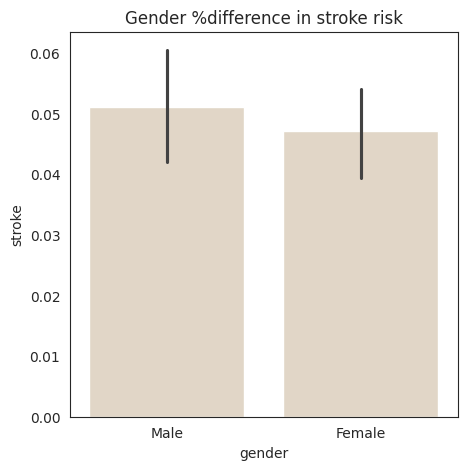

In [ ]:
plt.figure(figsize=(5, 5))
sns.barplot(x="gender", y="stroke", data=stroke)
plt.title("Gender %difference in stroke risk")

In [ ]:
descr_stats = stroke.groupby("gender")["stroke"]
std_p = lambda x: np.std(x, ddof=1)
se_p = lambda x: stats.sem(x, ddof=1)

descr_stats = descr_stats.agg([np.mean, std_p, se_p])
descr_stats.columns = ["mean stroke%", "std deviation", "std error"]
descr_stats.style.format("{:.3f}")

,mean stroke%,std deviation,std error
gender,,,
Female,0.047,0.212,0.004
Male,0.051,0.220,0.005


In [ ]:
women = stroke[stroke["gender"] == "Female"]["stroke"]
men = stroke[stroke["gender"] == "Male"]["stroke"]

In [ ]:
alpha = 0.05
t_stat, p_value = stats.ttest_ind(women, men, equal_var=True, alternative="less")
std_error = np.sqrt(np.var(women, ddof=1) / len(women) + np.var(men, ddof=1) / len(men))
df = len(women) + len(men) - 2
mean_difference = np.mean(women) - np.mean(men)
conf_int = stats.t.interval(0.95, df, loc=mean_difference, scale=std_error)

print(f"Difference in Means: {mean_difference:.4f}")
print(
    f"Confidence Interval for the Difference in Means: ({conf_int[0]:.4f}, {conf_int[1]:.4f})\n"
)
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}\n")

Difference in Means: -0.0040
Confidence Interval for the Difference in Means: (-0.0160, 0.0081)

t-statistic: -0.65
p-value: 0.2582



Men and women do not differ significantly in their likelihood of getting a stroke.

Then, we saw previously that more married than unmarried people suffered from a strike. However, of course the total amount of married people in our sample is larger than the amount of unmarried. Thus, we want to investigate whether there is a difference between married men and married women on the one hand, and their unmarried peers on the other hand, in the likelihood of getting a stroke.

H0: There is no difference in likelihood in the average amount of strokes amongst married and unmarried men and women.

H1: There is a difference in likelihood in the average amount of strokes amongst married and unmarried men and women.

In [ ]:
strokes_gender_marriage = (
    stroke.groupby(["gender", "ever_married"])
    .agg({"id": "count", "stroke": "sum"})
    .rename(columns={"id": "total_n", "stroke": "stroke_cases"})
)
strokes_gender_marriage["incidence"] = (
    strokes_gender_marriage.stroke_cases / strokes_gender_marriage.total_n
)
strokes_gender_marriage

total_n  stroke_cases  incidence
gender ever_married                                  
Female No                993            21       0.02
       Yes              2001           120       0.06
Male   No                763             8       0.01
       Yes              1352           100       0.07

In [ ]:
stroke["gender_marriage"] = stroke["gender"] + "_" + stroke["ever_married"]

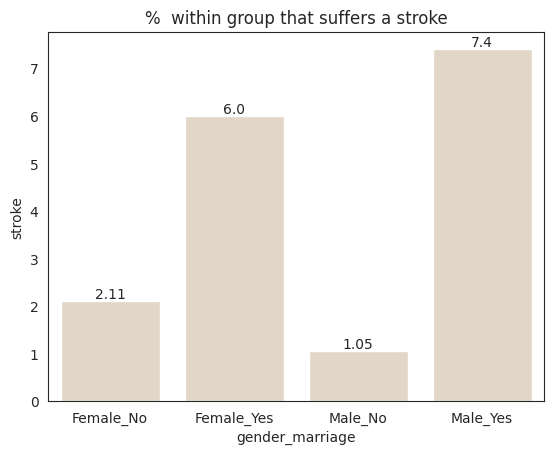

In [ ]:
gender_marriage = stroke.groupby("gender_marriage")[["stroke"]].mean()
gender_marriage.stroke = (gender_marriage.stroke * 100).round(2)
ax = sns.barplot(x=gender_marriage.index, y=gender_marriage["stroke"])
plt.title("%  within group that suffers a stroke")
for i, v in enumerate(gender_marriage["stroke"]):
    ax.text(i, v, str(v), ha="center", va="bottom", fontsize=10)

* Both married men and married women seem to be more likely to suffer from a stroke than unmarried men and women.
* For women, stroke incidence when married is about 4% higher compared to when unmarried, for men the difference is almost 6.5%.
* The percentage of married men suffering from a stroke seems to be higher than for married women, while the percentage unmarried men suffering a stroke is lower than for unmarried women.   

We do have to take into account that the married feature is unbalanced in our sample, 2/3 is married vs 1/3 unmarried, which could potentially skew the data.

In [ ]:
anova_quality = smf.ols("stroke ~ gender_marriage", data=stroke).fit()
aov_table = anova_lm(anova_quality, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
gender_marriage,2.99,3.00,21.72,0.00
Residual,233.88,"5,105.00",NaN,NaN


In [ ]:
tukey_results = pairwise_tukeyhsd(
    endog=stroke["stroke"], groups=stroke["gender_marriage"], alpha=0.05
)
print(tukey_results.summary())

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
 Female_No Female_Yes   0.0388    0.0  0.0175  0.0602   True
 Female_No    Male_No  -0.0107  0.729 -0.0371  0.0158  False
 Female_No   Male_Yes   0.0528    0.0  0.0298  0.0758   True
Female_Yes    Male_No  -0.0495    0.0 -0.0729 -0.0261   True
Female_Yes   Male_Yes    0.014 0.2469 -0.0054  0.0334  False
   Male_No   Male_Yes   0.0635    0.0  0.0386  0.0884   True
------------------------------------------------------------


* Married women are not significantly more likely to suffer from a stroke than married men. The same holds for unmarried women compared to unmarried men.
* When comparing unmarried and married, each unmarried group is significantly less likely to suffer from a stroke than each married group.

# Part 3: Data Pre-processing


The aim of this project is to create a model to predict as accurately as possible who is more likely to suffer a stroke and who not, and to find risk factors.

We will use the data we have of people that did and did not suffer a stroke to train a prediction model.

The stroke feature will serve as the target feature, which is binary with values representing our classes to be predicted:
- 0: no stroke
- 1: stroke

Firstly, we will prepare the dataset to be used in a binary classification model, creating a train-test split and a pre-processing pipeline, and create a baseline model against which we can compare later models.

In [ ]:
stroke_model = stroke.copy().drop(columns=(["id", "age_category", "gender_marriage"]))
stroke_model["stroke"].value_counts(normalize=True)

0   0.95
1   0.05
Name: stroke, dtype: float64

* We previously noticed the classes of our target feature are imblanced, with only 5% having an insurance and 96% not. We will downsample the majority class and use weights to give the minority class to attempt to restore the balance.

In [ ]:
train_set, test_set = train_test_split(
    stroke_model, test_size=0.2, random_state=2, stratify=stroke_model["stroke"]
)
print("n training set: ", len(train_set))
print("n test set: ", len(test_set))

n training set:  4087
n test set:  1022


In [ ]:
train_set["stroke"].value_counts()

0    3888
1     199
Name: stroke, dtype: int64

The training set contains 199 stroke cases vs 3888 non-strokes.
We will use a combination of downsampling the majority class, and applying weights when specifying a model, in an attempt to work up model performance despite the class imbalance.

In [ ]:
falses = train_set[train_set["stroke"] == 0].sample(n=2000, random_state=22)
trues = train_set[train_set["stroke"] == 1]

train_set_downsampled = pd.concat([falses, trues], axis=0)

X_train = train_set_downsampled.drop(columns=("stroke"))
y_train = train_set_downsampled["stroke"]

X_test = test_set.drop(columns=("stroke"))
y_test = test_set["stroke"].copy()

## Pipeline

In order to have all features processed in a similar way, we will create a pipeline for it, using the following steps:  
- Impute the mean for missing values, since this makes models perform better than when deleting cases with missings [source](https://www.kaggle.com/code/alexisbcook/missing-values)
- As for most ml models the data needs to be of similar range, we will use StandardScaler to transform features to have a mean of 0 and a standard deviation of 1 [source](https://learning.oreilly.com/library/view/machine-learning-with/9781491989371/ch04.html#rescaling-a-feature).
- Apply one-hot-encoding to be able for models to handles categorical features. Drop the base case as it will be correlated to the features of other levels.
- Add quadratic features for numerical variables.
- Add features for interaction between each two numerical variables.


In [ ]:
num_features = X_train.select_dtypes(include=["float64", "int64"])
text_features = X_train.select_dtypes(include=["object"])

num_attribs = list(num_features)
cat_attribs = list(text_features)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")), #iterativeimputer
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(drop="first"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_attribs),
        ("categorical", categorical_transformer, cat_attribs),
    ]
)

full_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

In [ ]:
num_names = list(
    full_pipeline.named_steps["preprocessor"]
    .transformers_[0][1]
    .get_feature_names_out()
)
cat_names = list(
    full_pipeline.named_steps["preprocessor"]
    .transformers_[1][1]
    .get_feature_names_out()
)

all_feature_names = num_names + cat_names
df_transformed = pd.DataFrame(X_train, columns=all_feature_names)

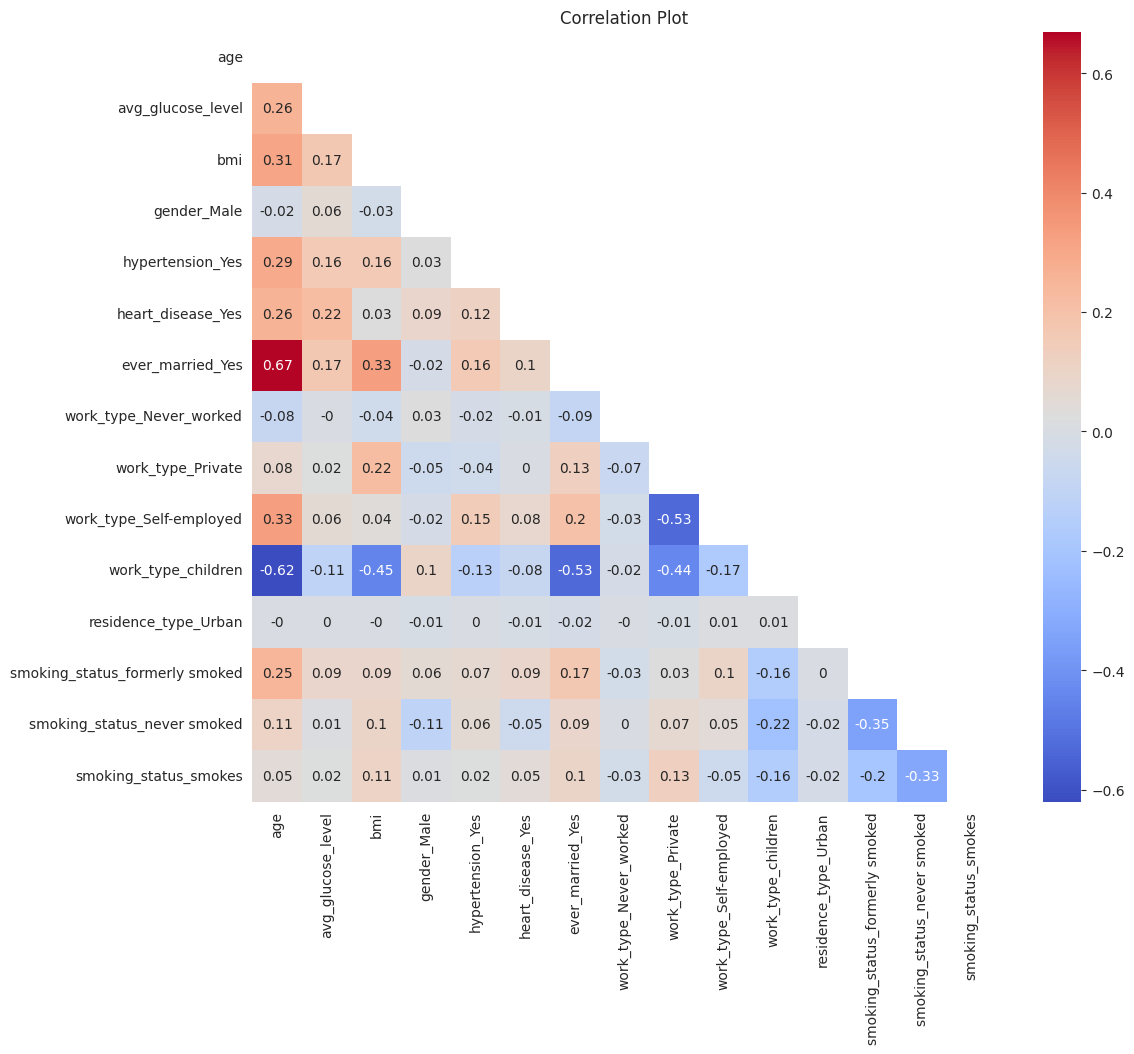

In [ ]:
plt.figure(figsize=(12, 10))
corr_matrix = df_transformed.corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", annot=True)
plt.title("Correlation Plot")
plt.show()

## Performance evaluation functions

In [ ]:
def evaluate_classification(model_name, x, y, pred_ylabels):
    """create a confusion matrix and classification report for a binary classification model"""
    cm = confusion_matrix(y, pred_ylabels)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
    ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white")
    print(
        "Classification report:\n",
        classification_report(y, pred_ylabels, zero_division=0),
    )


def calculate_ROC_AUC(y, prob_y):
    """Draw ROC curve and calculate AUC"""
    fpr, tpr, thresholds = roc_curve(y, prob_y, pos_label=1)
    roc_df = pd.DataFrame({"recall": tpr, "specificity": 1 - fpr})
    ax = roc_df.plot(x="specificity", y="recall", figsize=(4, 4), legend=False)
    ax.set_ylim(0, 1)
    ax.set_xlim(1, 0)
    ax.plot((1, 0), (0, 1))
    ax.set_xlabel("specificity")
    ax.set_ylabel("recall")
    ax.set_title("ROC curve")

    AUC = roc_auc_score([1 if yi == 1 else 0 for yi in y], prob_y)
    print("AUC: {:.2f}\n".format(AUC))

# Part 4: Data Modelling

We will now use different classficiation algorithms to fit a model on our dataset, in order to find out which is best at predicting cases that did and did not suffer a stroke.

Since the classes of our target feature are highly imbalanced, we will stick to tree-based models, as those are supposed to perform best in this case [source](https://learning.oreilly.com/library/view/machine-learning-pocket/9781492047537/ch09.html#idm46595581426696 )
We will slightly downsample the majority class and then adjust the class_weights hyperparameter. Only downsampling would make the total training sample so small that we could question the reliability of a model built on it. Upsampling however, would create a lot of duplicates, which isn't ideal neither.

Below we first run a LazyClassifier to choose which model types to use.




In [ ]:
clf = LazyClassifier(
    verbose=0, ignore_warnings=True, custom_metric=None, random_state=2
)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
predictions

100%|██████████| 29/29 [00:06<00:00,  4.23it/s]

[LightGBM] [Info] Number of positive: 199, number of negative: 2000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 2199, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090496 -> initscore=-2.307598
[LightGBM] [Info] Start training from score -2.307598


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.73,0.78,0.78,0.81,0.03
GaussianNB,0.28,0.62,0.62,0.38,0.02
Perceptron,0.85,0.62,0.62,0.88,0.07
QuadraticDiscriminantAnalysis,0.23,0.60,0.60,0.32,0.07
ExtraTreeClassifier,0.90,0.59,0.59,0.91,0.03
DecisionTreeClassifier,0.87,0.59,0.59,0.89,0.04
LGBMClassifier,0.93,0.59,0.59,0.93,0.21
LinearDiscriminantAnalysis,0.94,0.58,0.58,0.93,0.04
XGBClassifier,0.93,0.57,0.57,0.93,0.29


Since the classes of our target feature are imbalanced, we will use F1 as our performance metric to optimise. Another option would be AUC-ROC, as is is threshold-independent, meaning it considers the model's performance across all possible classification thresholds.
However, in our dataset the imbalance is that large that we will look at F1, the harmonic mean of the precision and recall.
F-Measure summarizes the model's capability for a specific probability threshold, whereas the area under the curve summarizes the capability of a model across thresholds.

We can see that bagging and boosting classifiers, logistic regression and knn are relatively good on F1, and support vector machines as well. Looking at AUC, the single tree and xgb seem the higher scoring tree models. Logistic regression, support vectors and knn are relatively less good on AUC.

Looking at speed, the slowest by far is XGBClassifier, while the LGBMClassifier is a boosted tree model too and a lot faster. Random forest and AdaBoostClassifier are medium fast, or slow when looking at the total model set.





## Single tree

We will first run and tune a single tree, so that we can later compare the performance with boosted tress and make a trade-off between simplicity, explainability and performance. In cases the performance differences are minimal, we might want to stick to the simpler, more easily explainable model of a single tree.

The performance metric most important here will be f1  as we want to avoid all kinds of misclassifications and therefore like to find the model that best maximizes both precision and recall. We will plot a  precision-recall curve with the final model to see how those two are traded off.

In [ ]:
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)

In [ ]:
decisiontree = DecisionTreeClassifier(
    class_weight=dict(zip(np.unique(y_train), class_weights)), random_state=45
)

scores = cross_validate(
    decisiontree,
    X_train,
    y_train,
    cv=10,
    scoring=["precision", "f1", "roc_auc"],
    n_jobs=-1,
)
precision_scores = scores["test_precision"]
f1_scores = scores["test_f1"]
roc_auc_scores = scores["test_roc_auc"]

print(
    f" Average F1: {f1_scores.mean():.2f}\n Average AUC: {roc_auc_scores.mean():.2f}\n Average Precision: {precision_scores.mean():.2f}"
)

 Average F1: 0.18
 Average AUC: 0.55
 Average Precision: 0.19


F1 and precision seem pretty poor, AUC is just over 0.5 thus meaning it's only very minimally better than randomly guessing (50-50 chance). Below we will tune hyperparameters, using F1 as our scoring metric.

### Tree tuning

In [ ]:
params_tree = {
    "max_depth": [4, 6, 8],
    "min_samples_split": [10, 100, 1000],
    "max_features": ["sqrt", "log2"],
}

In [ ]:
random_search = RandomizedSearchCV(
    decisiontree,
    param_distributions=params_tree,
    n_iter=200,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    random_state=2,
)

In [ ]:
random_search.fit(X_train, y_train)
best_CV_score = random_search.best_score_
print(f"Best cross-validated mean F1 score: {best_CV_score:.3f}")

Best cross-validated mean F1 score: 0.318


After running an initial randomsearchcv, we worked the cross-validated F1 score up from 0.16 to 0.31. Let's take a look at the validation curves of our tuned hyperparameters.   

In [ ]:
best_hyperparams = random_search.best_params_
print(f"Best hyperparameters:\n {best_hyperparams}\n")

Best hyperparameters:
 {'min_samples_split': 100, 'max_features': 'sqrt', 'max_depth': 4}



In [ ]:
tuned_tree = random_search.best_estimator_

y_pred_tunedtree = tuned_tree.predict(X_test)
f1_test = f1_score(y_test, y_pred_tunedtree, average="binary")
print(f"Test set f1 score of tuned tree: {f1_test:.3f}")
precision_test = precision_score(y_test, y_pred_tunedtree, average="binary")
print(f"Test set precision score of tuned tree: {precision_test:.3f}")

Test set f1 score of tuned tree: 0.220
Test set precision score of tuned tree: 0.125


The cross-validated accuracy and test set accuracy are quite far from each other, thus the tree still does seem to be overfitting.
Let's try out if the ensemble methods are better at working with imbalanced class data.  

## Cross-validation overview

Below we check out the performance of several gradient boosting methods, and compare back to the tuned single tree.

In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
roc_auc = []
precision = []
f1 = []
classifiers = [
    "RandomForest",
    "GradientBoostingClassifier",
    "XGBoost",
    "LightGBM",
    "CatBoost",
]
models = [
    RandomForestClassifier(random_state=2),
    GradientBoostingClassifier(random_state=2),
    XGBClassifier(random_state=2),
    LGBMClassifier(random_state=2),
    CatBoostClassifier(random_seed=2),
]

for model, clf_name in zip(models, classifiers):
    scoring = {"precision": "precision", "f1": "f1", "roc_auc": "roc_auc"}
    cv_results = cross_validate(
        model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1
    )
    precision.append(cv_results["test_precision"].mean())
    f1.append(cv_results["test_f1"].mean())
    roc_auc.append(cv_results["test_roc_auc"].mean())

cv_dataframe = pd.DataFrame(
    {
        "AUC": roc_auc,
        "F1": f1,
        "Precision": precision,
    },
    index=classifiers,
)
cv_dataframe

,AUC,F1,Precision
RandomForest,0.80,0.05,0.26
GradientBoostingClassifier,0.82,0.10,0.29
XGBoost,0.78,0.23,0.32
LightGBM,0.80,0.20,0.34
CatBoost,0.81,0.12,0.31


XGBoost has highest F1 score, while GradientBoostingClassifier is highest in AUC. RandomForest is least good on most metrics.

Lightgbm is highest in precision. However, Lightgbm is different from other gradient boosting frameworks as it uses a leaf-wise tree growth algorithm while most use a depth-wise tree growth. Leaf-wise methods allow the trees to converge faster which is beneficial when having big data (<10000 records), but since with this method the chance of over-fitting increases, it might not be great for a small dataset like ours [source](https://neptune.ai/blog/lightgbm-parameters-guide).

Thus, we will tune XGBoost and GradientBoostingClassifier and compare performance.


# Ensembles

We will now try out several gradient boosting ensembles, and compare performance amongst them.  
The advantage of boosting is that while it runs the model iteratively like all ensembles, and recognises which samples were misclassified in each iteration, which then in the next run get extra weight.

## GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier(random_state=42)

scores = cross_validate(
    gbc, X_train, y_train, cv=10, scoring=["precision", "f1", "roc_auc"], n_jobs=-1
)
precision_scores = scores["test_precision"]
f1_scores = scores["test_f1"]
roc_auc_scores = scores["test_roc_auc"]

print(
    f" Average F1: {f1_scores.mean():.2f}\n Average AUC: {roc_auc_scores.mean():.2f}\n Average Precision: {precision_scores.mean():.2f}"
)

 Average F1: 0.09
 Average AUC: 0.82
 Average Precision: 0.37


### Gradient Booster tuning

- `learning_rate` [default=0.1] determines the contribution of each tree. Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators. Values must be in the range [0.0, inf).
- `n_estimators` [default=3] number of boosting rounds. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance. Values must be in the range [1, inf).
- `max_depth` [default=3] is the maximum depth of each estimator (tree). The depth of a tree corresponds to the number of nodes from the root to the deepest leaf. If None, then nodes are expanded until all leaves are pure or until all leaves contain the amount of min_samples_split samples. Values must be in the range [1, inf).
- `subsample` [default=1.0] the proportion of samples to be used in each iteration. Interacts with the parameter `n_estimators`. Choosing `subsample` < 1.0 leads to a reduction of variance, making the model more stable and better performing on new data. However, it can increase bias if the subsets aren't representative. Values must be in the range (0.0, 1.0].


In [ ]:
params_gbc = {
    "learning_rate": uniform(0, 5),
    "n_estimators": [10, 100, 1000],
    "max_depth": [3, 4, 5],
    "subsample": uniform(0, 1),
}

In [ ]:
random_search_gbc = RandomizedSearchCV(
    gbc,
    param_distributions=params_gbc,
    n_iter=100,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    random_state=2,
)

In [ ]:
random_search_gbc.fit(X_train, y_train, )
best_CV_score = random_search_gbc.best_score_
print(f"Best cross-validated mean F1 score: {best_CV_score:.3f}")

Best cross-validated mean F1 score: 0.328


After running an initial randomsearchcv, we worked the cross-validated F1 score up from 0.23 to 0.36. Let's take a look at the validation curves of our tuned
hyperparameters.   




In [ ]:
best_hyperparams = random_search_gbc.best_params_
print(f"Best hyperparameters:\n {best_hyperparams}\n")

Best hyperparameters:
 {'learning_rate': 1.6143710671597822, 'max_depth': 4, 'n_estimators': 10, 'subsample': 0.9831534453572127}



The model that is selected as the best model, does not have all optimal parameter values as seen in the graphs. The hyperparameters stored in .best_params_ correspond to the combination that maximizes the mean_test_score.
we would like to find out how the model performs on the test data.

In [ ]:
tuned_gbc = random_search_gbc.best_estimator_

y_pred_tunedgbc = tuned_gbc.predict(X_test)
f1_test = f1_score(y_test, y_pred_tunedgbc, average="binary")
print(f"Test set f1 score of tuned model: {f1_test:.3f}")
precision_test = precision_score(y_test, y_pred_tunedgbc, average="binary")
print(f"Test set precision score of tuned model: {precision_test:.3f}")

Test set f1 score of tuned model: 0.230
Test set precision score of tuned model: 0.158


Classification report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92       972
           1       0.16      0.42      0.23        50

    accuracy                           0.86      1022
   macro avg       0.56      0.65      0.58      1022
weighted avg       0.93      0.86      0.89      1022



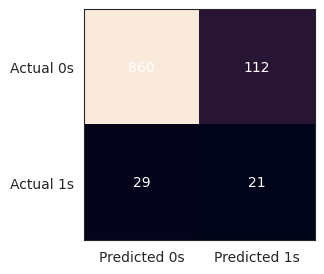

In [ ]:
evaluate_classification(tuned_gbc, X_test, y_test, y_pred_tunedgbc)

The test set F1 score of 23% is a lot lower than the tuned model's cross-validated score of 33%.
Precision of the class 1 predictions is only 16%. Recall is low too at 42%.

In [ ]:
params_gbc2 = {
    "learning_rate": [1.4, 1.6, 2],
    "n_estimators": [10, 100, 200],
    "max_depth": [4],
}

In [ ]:
grid_search = GridSearchCV(
    tuned_gbc, param_grid=params_gbc2, scoring="f1", cv=5, n_jobs=-1
)

In [ ]:
grid_search.fit(X_train, y_train)

best_hyperparams = grid_search.best_params_
print(f"Best hyperparameters:\n {best_hyperparams}\n")

best_CV_score = grid_search.best_score_
print(f"Best cross-validated mean F1 score: {best_CV_score:.3f}")

Best hyperparameters:
 {'learning_rate': 1.6, 'max_depth': 4, 'n_estimators': 200}

Best cross-validated mean F1 score: 0.304


In [ ]:
tuned_gbc2 = grid_search.best_estimator_

y_pred_tunedgbc2 = tuned_gbc2.predict(X_test)
f1_test = f1_score(y_test, y_pred_tunedgbc2, average="binary")
print(f"Test set f1 score of tuned model: {f1_test:.3f}")
f1_test = precision_score(y_test, y_pred_tunedgbc2, average="binary")
print(f"Test set precision score of tuned model: {f1_test:.3f}")

Test set f1 score of tuned model: 0.156
Test set precision score of tuned model: 0.095


Classification report:
               precision    recall  f1-score   support

           0       0.96      0.78      0.86       972
           1       0.09      0.44      0.16        50

    accuracy                           0.77      1022
   macro avg       0.53      0.61      0.51      1022
weighted avg       0.92      0.77      0.83      1022



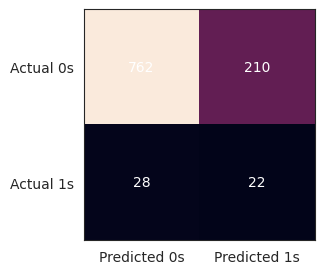

In [ ]:
evaluate_classification(tuned_gbc2, X_test, y_test, y_pred_tunedgbc2)

## XGBoost

In [ ]:
XGboost = XGBClassifier(objective="binary:logistic", random_state=2)

scores = cross_validate(
    XGboost,
    X_train,
    y_train,
    cv=StratifiedKFold(10),
    scoring=["precision", "f1", "roc_auc"],
    n_jobs=-1,
)
precision_scores = scores["test_precision"]
f1_scores = scores["test_f1"]
roc_auc_scores = scores["test_roc_auc"]

print(
    f" Average F1: {f1_scores.mean():.2f}\n Average AUC: {roc_auc_scores.mean():.2f}\n Average Precision: {precision_scores.mean():.2f}"
)

 Average F1: 0.16
 Average AUC: 0.78
 Average Precision: 0.26


In [ ]:
XGboost.fit(X_train, y_train)

y_pred_base = XGboost.predict(X_test)
f1_test = f1_score(y_test, y_pred_base, average="binary")
print(f"Test set f1 score of base model: {f1_test:.3f}")

Test set f1 score of base model: 0.202


### Hyperparameter tuning

- `scale_pos_weight`: used to restore imbalance, suggested value: sum(neg instances)/sum(pos instances) (2000/199).
- `eta` [default=0.3, alias: learning_rate]. Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative. range: [0,1]

- `gamma` [default=0, alias: min_split_loss]. Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. range: [0,∞]

- `max_depth` [default=6]. The amount of layers or levels a tree has. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. range: [0,∞]

- `lambda` [default=1, alias: reg_lambda]. L2 regularization term on weights. Increasing this value will make the model more conservative. range: [0,∞]

https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster

In [ ]:
params_xgb = {
    "scale_pos_weight": uniform(5, 12),
    "eta": uniform(0.01, 3),
    "gamma": uniform(0, 10),
    "max_depth": [3, 4, 5],
    "lambda": uniform(0, 10),
}

In [ ]:
random_search = RandomizedSearchCV(
    XGboost,
    param_distributions=params_xgb,
    n_iter=200,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    random_state=2,
)

In [ ]:
random_search.fit(X_train, y_train)
best_CV_score = random_search.best_score_
print(f"Best cross-validated mean F1 score: {best_CV_score:.3f}")

Best cross-validated mean F1 score: 0.388


After running an initial randomsearchcv, we worked the cross-validated F1 score up from 0.16 to 0.39.  




In [ ]:
df_cvrresults = pd.DataFrame(random_search.cv_results_)

In [ ]:
best_hyperparams = random_search.best_params_
print(f"Best hyperparameters:\n {best_hyperparams}\n")

Best hyperparameters:
 {'eta': 0.01662711984052056, 'gamma': 6.4461034810830675, 'lambda': 3.2202767186978223, 'max_depth': 3, 'scale_pos_weight': 5.188665475444667}



The model that is selected as the best model, does not have all optimal parameter values as seen in the graphs.
we would like to compare performance on CV train data (4 folds) with performance on CV test data (1 fold), in order to find out whether it is overfitting, like the tree did previously.

In [ ]:
df_cvrresults[
    ["mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]
].head(10)

,mean_train_score,std_train_score,mean_test_score,std_test_score
0,0.98,0.01,0.26,0.03
1,0.68,0.02,0.33,0.03
2,0.63,0.15,0.23,0.04
3,0.43,0.13,0.26,0.07
4,0.67,0.05,0.31,0.04
5,0.63,0.25,0.25,0.06
6,0.68,0.03,0.30,0.03
7,0.65,0.11,0.25,0.04
8,0.46,0.22,0.21,0.03
9,0.65,0.04,0.29,0.02


There is quite a big discrepancy between cv train and cv test scores, meaning the model is overfitting.

In [ ]:
tuned_xgb = random_search.best_estimator_

y_pred_tunedxgb = tuned_xgb.predict(X_test)
f1_test = f1_score(y_test, y_pred_tunedxgb, average="binary")
print(f"Test set f1 score of tuned model: {f1_test:.3f}")
precision_test = precision_score(y_test, y_pred_tunedxgb, average="binary")
print(f"Test set precision score of tuned model: {precision_test:.3f}")

Test set f1 score of tuned model: 0.258
Test set precision score of tuned model: 0.164


Classification report:
               precision    recall  f1-score   support

           0       0.98      0.84      0.90       972
           1       0.16      0.60      0.26        50

    accuracy                           0.83      1022
   macro avg       0.57      0.72      0.58      1022
weighted avg       0.94      0.83      0.87      1022



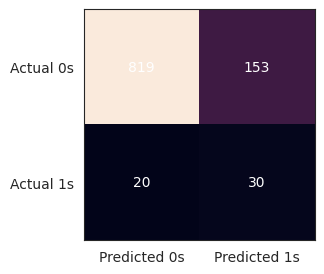

In [ ]:
evaluate_classification(tuned_xgb, X_test, y_test, y_pred_tunedxgb)

The F1 score is actually similar to that of the untuned model's cross-validated score, but much lower than the tuned model's cv score, meaning it is overfitting on the training data.
We have of course imbalanced classes which doesn't work in our advantage. A potential other reason might be the small size of the dataset. The model might be too complex for the amount of data we have. As we are not able to add more training data, we could try to reduce the classifier's complexity.

We will now look into changing hyperparameters in order to restrict the model, in an attempt to prevent overfitting, as suggested [here](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html)

There are a few options:

- The first way is to directly control model complexity by setting lower max_depth (as higher depth will make the model more complex and more likely to overfit), and higher gamma. The larger gamma is, the more conservative the algorithm will be.

- The second way is to add randomness to make training robust to noise. If for example you set 'subsample' to 0.5, this means we do not use all cases of our data, but only 50% randomly selected per tree.
Then with 'colsample_bytree', for example if you set this to 0.5, it will only use 50% of the features per tree.  

We can also reduce stepsize eta or learning_rate, as step size shrinkage prevents overfitting.

In [ ]:
params_xgb2 = {
    "scale_pos_weight": [8, 9, 10],
    "eta": [0.3, 0.5, 1],
    "gamma": [5, 10, 15],
    "max_depth": [2, 3, 4],
}

In [ ]:
random_search2 = GridSearchCV(
    XGboost, param_grid=params_xgb2, scoring="f1", cv=5, n_jobs=-1
)

In [ ]:
random_search2.fit(X_train, y_train)

best_hyperparams = random_search2.best_params_
print(f"Best hyperparameters:\n {best_hyperparams}\n")

best_CV_score = random_search2.best_score_
print(f"Best cross-validated mean F1 score: {best_CV_score:.3f}")

Best hyperparameters:
 {'eta': 0.3, 'gamma': 10, 'max_depth': 3, 'scale_pos_weight': 8}

Best cross-validated mean F1 score: 0.366


In [ ]:
tuned_xgb2 = random_search2.best_estimator_

y_pred_tunedxgb = tuned_xgb2.predict(X_test)
f1_test = f1_score(y_test, y_pred_tunedxgb, average="binary")
print(f"Test set f1 score of tuned model: {f1_test:.3f}")
precision_test = precision_score(y_test, y_pred_tunedxgb, average="binary")
print(f"Test set precision score of tuned model: {precision_test:.3f}")

Test set f1 score of tuned model: 0.255
Test set precision score of tuned model: 0.151


Classification report:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.15      0.84      0.26        50

    accuracy                           0.76      1022
   macro avg       0.57      0.80      0.56      1022
weighted avg       0.95      0.76      0.83      1022



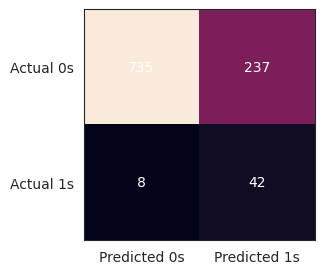

In [ ]:
evaluate_classification(tuned_xgb2, X_test, y_test, y_pred_tunedxgb)

The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets.

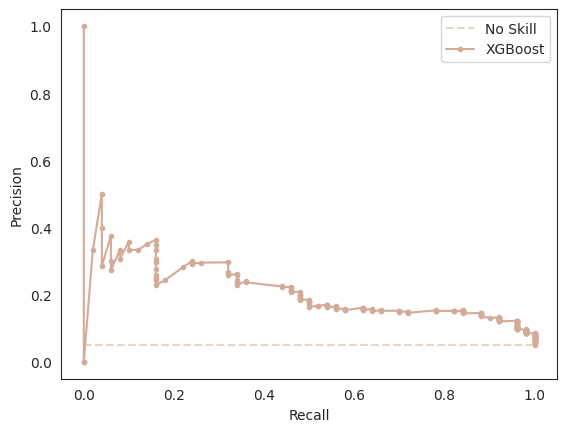

In [ ]:
lr_probs = tuned_xgb2.predict_proba(X_test)[:, 1]
lr_probs = lr_probs

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1 = f1_score(y_test, y_pred_tunedxgb)
no_skill = len(y_test[y_test == 1]) / len(y_test)

plt.plot([0, 1], [no_skill, no_skill], linestyle="--", label="No Skill")
plt.plot(lr_recall, lr_precision, marker=".", label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

We can see that there is a trade-off between precision and recall. Precision does not get very high at any point at all, the best value would be 0.5, however with that, recall clearly suffers as it will only be around 0.05 at that point.
It seems easier to reach higher recall values, when recall is 0.5 and up, precision does not change much but stays around 0.17.
This is also what we notice with the two tuning rounds, as with the second the recall went up by 0.24 while precision only went down by 0.01, while F1 remained roughly equal.


#Part 5: Model interpretation



### Feature importance

We will now look at which features were most influential in determining our target feature.
We use a few different methods and compare results, first the XGB native method, for which we can use to look at importance in different ways:
- Weight: the number of times a feature is used to split the data across all trees.
- Cover: the number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
- Gain: the average training loss reduction gained when using a feature for splitting.
[source](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)

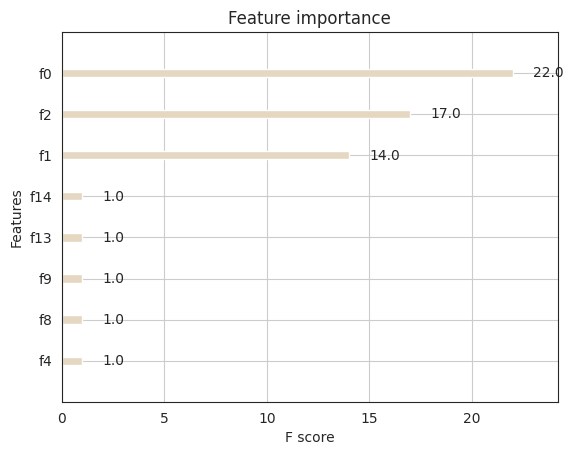

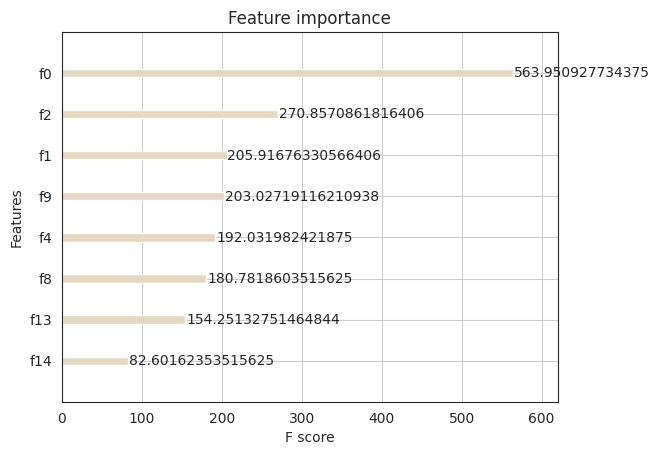

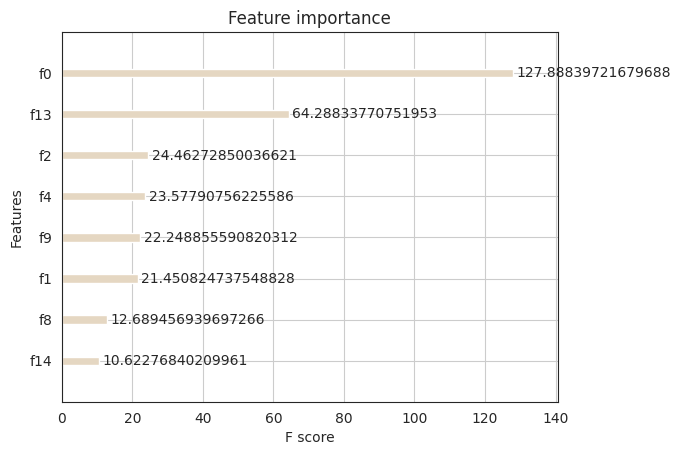

In [ ]:
importance_argument = ["weight", "cover", "gain"]

for arg in importance_argument:
    xgb.plot_importance(tuned_xgb2, importance_type=arg)

In [ ]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199 entries, 0 to 2198
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             2199 non-null   float64
 1   avg_glucose_level               2199 non-null   float64
 2   bmi                             2199 non-null   float64
 3   gender_Male                     2199 non-null   float64
 4   hypertension_Yes                2199 non-null   float64
 5   heart_disease_Yes               2199 non-null   float64
 6   ever_married_Yes                2199 non-null   float64
 7   work_type_Never_worked          2199 non-null   float64
 8   work_type_Private               2199 non-null   float64
 9   work_type_Self-employed         2199 non-null   float64
 10  work_type_children              2199 non-null   float64
 11  residence_type_Urban            2199 non-null   float64
 12  smoking_status_formerly smoked  21

Age is the most important feature in all 3 graphs, glucose levels and bmi seem to be
second and third most important with both the weight and cover arguments. Using weight, all other features have no importance,
using cover, other features seem to have somewhat of an influence still.
Using gain, the results are likely to be similar in the next section when using permutation importance.

### Permutation
We can also use the permutation importance method to compare feature importance, this method calculates for each feature how much our model performance decreases when leaving this particular feature out. We will use F1 as a performance metric here. The weights in the table below show how much F1 goes down when leaving the feature out.  

In [ ]:
f1_scorer = make_scorer(f1_score)
perm = PermutationImportance(tuned_xgb2, random_state=1, scoring=f1_scorer).fit(
    X_test, y_test
)
eli5.show_weights(perm, feature_names=all_feature_names)

Weight,Feature
0.1338 ± 0.0470,age
0.0159 ± 0.0117,smoking_status_never smoked
0.0119 ± 0.0129,bmi
0.0008 ± 0.0014,work_type_Private
0.0002 ± 0.0006,smoking_status_smokes
0 ± 0.0000,smoking_status_formerly smoked
0 ± 0.0000,residence_type_Urban
0 ± 0.0000,work_type_children
0 ± 0.0000,work_type_Self-employed
0 ± 0.0000,work_type_Never_worked


We can see from the table that results are similar as with the previous importance graphs. The age feature is most important in determining whether someone is at risk of getting a stroke.   
Except for age, never having smoked and bmi seem to be somewhat influential, however most other features have a very small weight.
Glucose levels do not seem to be important here.

These weights however don't tell us how much each feature matters. Age could have a large effect in higher age ranges, for example when comparing a 40 and an 80 year old person, age is likely able to explain the difference in risk. However, at lower age ranges, for example between 30 and 40, other factors might have more value in explaining why one gets a stroke and another person not.

### Mean SHAP
With the graph below we aim to get more insight in how features influence invidually observed values.

Positive SHAP values contribute to increasing the model's output, while negative values contribute to decreasing it.
The spread of dots for a particular feature gives an indication of how much the feature influences model predictions across different instances.
The color of the dot indicates the value of the feature (red for high values, blue for low values).

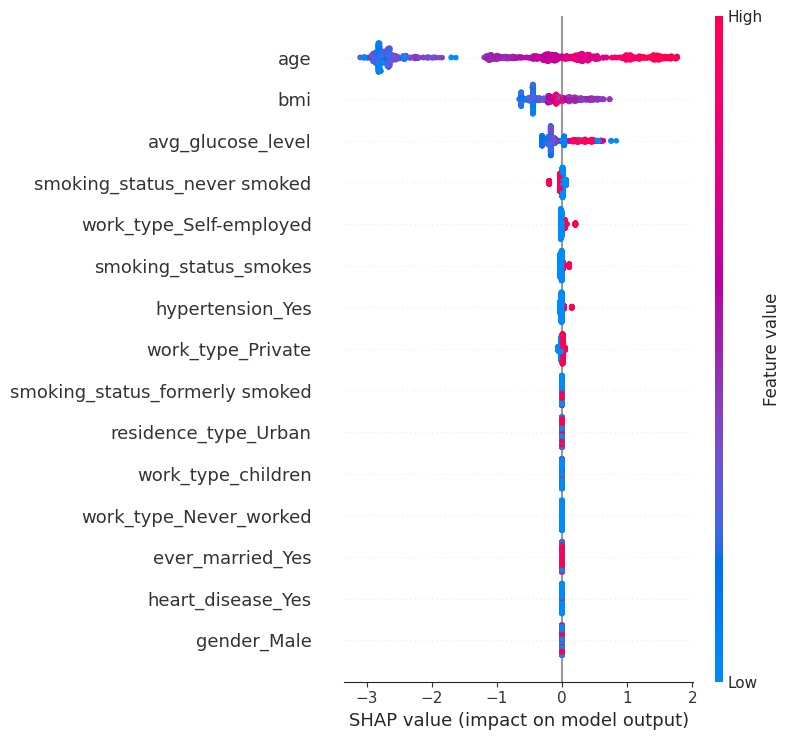

In [ ]:
explainer = shap.TreeExplainer(tuned_xgb2)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=all_feature_names)

The SHAP method seems to agree that age is the most important feature determining the outcome of our predictive model. Age has the most consistent relation with the target, looking at the colours and SHAP value pattern.
Bmi and avg glucose levels are also showing some spread here, however the colour patterns are a bit more mixed.
Below we look at relationships amongst age, bmi and glucose levels.

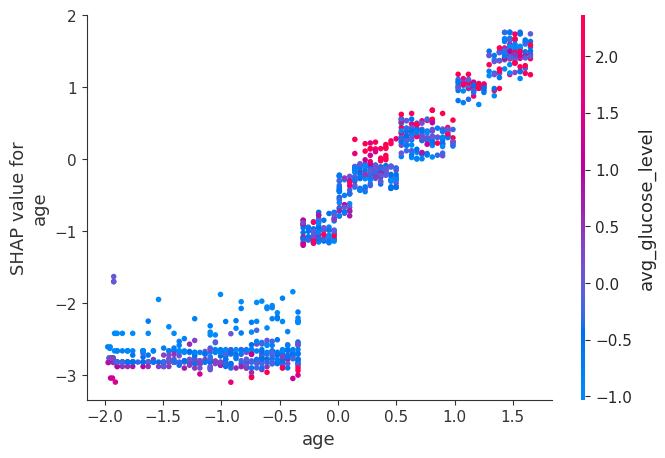

In [ ]:
shap.dependence_plot("age", shap_values, X_test, feature_names=all_feature_names)

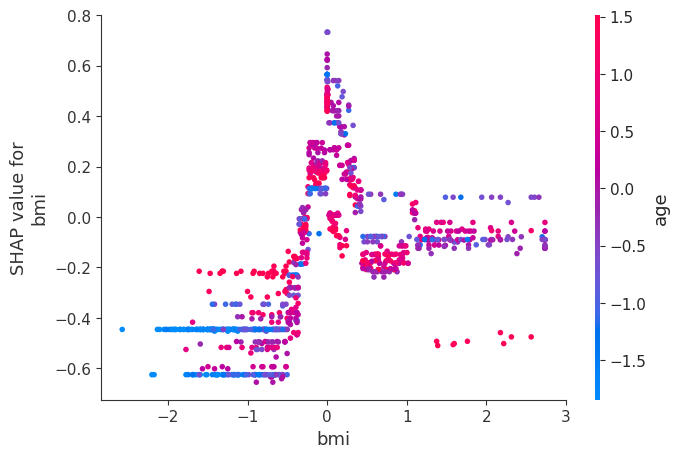

In [ ]:
shap.dependence_plot("bmi", shap_values, X_test, feature_names=all_feature_names)

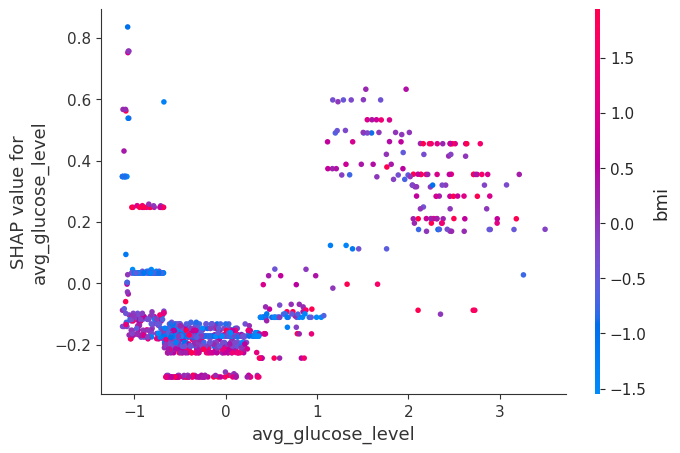

In [ ]:
shap.dependence_plot(
    "avg_glucose_level", shap_values, X_test, feature_names=all_feature_names
)

# Part 6: Individual observations

Let's imagine the model will be used by doctors to predict risk of getting a stroke for their patients.
The model will need to be integrated into some program or application that doctors are using, where they for example could fill out the data they have about patients that resemble the features in our dataset. Then they click on predict and in the background our model comes into action to predict a response, which then becomes visible to them on screen.

They might want to know for each case what exactly makes the application decide that this person is at risk or not, like which factors had most impact in the prediction, in order for them to know what to prescribe the patient. If bmi or glucose levels for example were an influential factor, they might advise the patient to revise his/her diet. However, if age was an influential factor there is not much we can do about it.

To be able to look at individual cases, we will use shap values below.

### SHAP

We pick case [7] here to analyse, this is a random pick. We will first look at the model's predicted probability of getting a stroke for this case.

In [ ]:
data_for_prediction_array = X_train[7].reshape(1, -1)
tuned_xgb2.predict_proba(data_for_prediction_array)

array([[0.89021885, 0.10978115]], dtype=float32)

This person is 89% likely to not get a stroke, and thus only 11% likely to get a stroke, according to the model. Now we wonder why the model thinks this person is not likely to get a stroke.

In [ ]:
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[7],
    features=X_train[7],
    feature_names=all_feature_names,
)

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.
We see here that the output of -3.58 is a lot lower than the base value of -0.27. The values of age and bmi in this case seem to lower the chances of getting a stroke, with age playing the biggest role.

# Part 7: Deployment


We will now make the model ready for deployment, to be opened from and used in an application.

## Downsized model
We will now retrain the XGBoost model only with the three features that are identified as influential for predicting stroke.

* First we limit the dataset to only three features plus the target.
* Since XGBoost can handle missings, scaling and category encoding itself, we do not pre-process the data before running the model.
* Hyperparameter tuning is unavoidable though, as our classes are heavily imbalanced we need to prevent the model from predicting all cases as the majority class.

In [ ]:
stroke_downsized = stroke_model[["age", "avg_glucose_level", "bmi", "stroke"]]
train_set_ds, test_set_ds = train_test_split(
    stroke_downsized, test_size=0.2, random_state=2, stratify=stroke_downsized["stroke"]
)

train_set_ds["stroke"].value_counts()

0    3888
1     199
Name: stroke, dtype: int64

In [ ]:
X_train = train_set_ds.drop(columns=("stroke"))
y_train = train_set_ds["stroke"]

X_test = test_set_ds.drop(columns=("stroke"))
y_test = test_set_ds["stroke"].copy()
y_test.value_counts()

0    972
1     50
Name: stroke, dtype: int64

In [ ]:
scores = cross_validate(
    XGboost,
    X_train,
    y_train,
    cv=StratifiedKFold(10),
    scoring=["precision", "f1", "roc_auc"],
    n_jobs=-1,
)
precision_scores = scores["test_precision"]
f1_scores = scores["test_f1"]
roc_auc_scores = scores["test_roc_auc"]

print(
    f" Average F1: {f1_scores.mean():.2f}\n Average AUC: {roc_auc_scores.mean():.2f}\n Average Precision: {precision_scores.mean():.2f}"
)

 Average F1: 0.10
 Average AUC: 0.78
 Average Precision: 0.19


In [ ]:
compact_model = XGboost.fit(X_train, y_train)

y_pred_base = XGboost.predict(X_test)
f1_test = f1_score(y_test, y_pred_base, average="binary")
print(f"Test set f1 score of base model: {f1_test:.3f}")

Test set f1 score of base model: 0.085


In [ ]:
params_xgb = {
    "scale_pos_weight": uniform(18, 22),
    "eta": uniform(0.01, 3),
    "gamma": uniform(0, 10),
    "max_depth": [3, 4, 5],
    "lambda": uniform(0, 10),
}

In [ ]:
random_search = RandomizedSearchCV(
    compact_model,
    param_distributions=params_xgb,
    n_iter=200,
    scoring="f1",
    cv=StratifiedKFold(5),
    n_jobs=-1,
    return_train_score=True,
    random_state=2,
)

In [ ]:
compact_tuned = random_search.fit(X_train, y_train)
best_CV_score = compact_tuned.best_score_
print(f"Best cross-validated mean F1 score: {best_CV_score:.3f}")

Best cross-validated mean F1 score: 0.244


In [ ]:
best_hyperparams = compact_tuned.best_params_
print(f"Best hyperparameters:\n {best_hyperparams}\n")

Best hyperparameters:
 {'eta': 0.01662711984052056, 'gamma': 6.4461034810830675, 'lambda': 3.2202767186978223, 'max_depth': 3, 'scale_pos_weight': 18.34588670498189}



Classification report:
               precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.15      0.80      0.25        50

    accuracy                           0.76      1022
   macro avg       0.57      0.78      0.55      1022
weighted avg       0.95      0.76      0.83      1022



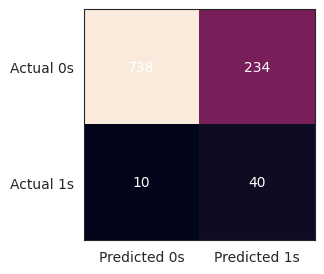

In [ ]:
y_pred_compact = compact_tuned.predict(X_test)
evaluate_classification(compact_tuned, X_test, y_test, y_pred_compact)

* We can see that with new data, the model is pretty reasonable at classifying actual stroke cases as strokes, it predicts it correctly for 76% of cases that actually had a stroke, only producing 12 false negatives.
* The model is however making a lot of mispredictions in the form of false positives. The majority, 85% cases, that the model predicted to get a stroke did not actually get a stroke. This makes the model not useful in reality, indicating for too many people that they are at risk while they aren't.

For practice, we deployed the model in a web app, to be opened in the browser here

In [ ]:
with open("compact_tuned.pkl", "wb") as f:
    pickle.dump(compact_tuned, f)

In [ ]:
def get_prediction(age, avg_glucose_level, bmi):
    with open("compact_tuned.pkl", "rb") as f:
        compact_tuned = pickle.load(f)
    data = np.array([age, avg_glucose_level, bmi]).reshape(1, -1)
    prediction = compact_model.predict(data)
    binary_prediction = "High risk" if prediction == 1 else "Low risk"
    return binary_prediction


demo = gr.Interface(
    fn=get_prediction,
    inputs=["number", "number", "number"],
    outputs="text",
)

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7e11d10836cf403830.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Conclusion

In this project we focused on creating a model to predict whether a person is likely to get a stroke or not, based on several behavioural and physical characteristics. In addition to that we focused on identifying potential risk factors.

**Method:**
- Binary classification algorithms
- Binary target: stroke or no stroke (1/0)
- 80:20 train-test ratio
- Primary performance metric: F1.
- Additional performance metrics: precision

**Result:**

First we trained and tuned a single decision tree, and after that we trained and tuned two boosters.
Our best model was the tuned XGBoost, which reached an F1 score of 0.26 and precision of 0.15

**Feature importance:**

Age had most predictive value in this model, according to all feature importance measuring methods we used. Bmi and glucose levels also seemed somewhat influential.

**Limitations:**

The final model has a very low precision, with a false positive rate of 85%, and also has a too high false negative rate of 25%, making it not useful for predicting stroke cases.
We might be missing factors that do predict